In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Input
import pandas as pd
import numpy as np
from numpy import array
from sklearn.model_selection import train_test_split


In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
df = pd.read_csv('scaled_combined_data.csv')
df.shape

(1137279, 41)

In [4]:
df['activity'] = df['activity'].map({'standing': 0, 'going_down': 1, 'walking': 2, 'up_by_elevator': 3, 'down_by_elevator': 4, 'going_up': 5, 'running': 6, 'sitting_down': 7, 'sitting': 8, 'standing_up': 9 })
df.shape

(1137279, 41)

In [5]:
data = df.iloc[:, 1:40]
data
print("After iloc:", type(data))


After iloc: <class 'pandas.core.frame.DataFrame'>


In [6]:
print(df['activity'].unique())

[0 1 2 3 4 5 6 7 8 9]


In [7]:
print(type(data))


<class 'pandas.core.frame.DataFrame'>


In [8]:
data = data.to_numpy(dtype=np.float32)

In [9]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [10]:
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(data, n_steps)
print(X.shape, y.shape)
# summarize the data
#for i in range(len(X)):
	#print(X[i], y[i])
    

(1137277, 3, 38) (1137277,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((909821, 3, 38), (227456, 3, 38), (909821,), (227456,))

In [14]:
n_features= X_train.shape[2]

In [14]:
from keras_tuner import HyperModel
from tensorflow import keras
from tensorflow.keras import layers
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_steps, n_features)))
    
    # Tune the number of filters for Conv1D layer
    model.add(layers.Conv1D(
        filters=hp.Choice('filters', [32, 64, 128]),
        kernel_size=hp.Choice('kernel_size', [2, 3, 5]),
        activation='relu'))
    
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    
    # Tune units of the first Dense layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'))
    
    # Output layer: assuming 10 classes with softmax
    model.add(layers.Dense(10, activation='softmax'))
    
    # Compile model, optionally tune learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [15]:
import keras_tuner

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=5)

Reloading Tuner from .\untitled_project\tuner0.json


In [16]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

In [15]:
model = Sequential([
    Input(shape=(n_steps, n_features)),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [16]:
history = model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
7108/7108 [==============================] - 45s 5ms/step - loss: 0.5246 - accuracy: 0.7900
Epoch 2/100
7108/7108 [==============================] - 37s 5ms/step - loss: 0.4228 - accuracy: 0.8180
Epoch 3/100
7108/7108 [==============================] - 37s 5ms/step - loss: 0.3969 - accuracy: 0.8262
Epoch 4/100
7108/7108 [==============================] - 37s 5ms/step - loss: 0.3799 - accuracy: 0.8334
Epoch 5/100
7108/7108 [==============================] - 37s 5ms/step - loss: 0.3663 - accuracy: 0.8408
Epoch 6/100
7108/7108 [==============================] - 37s 5ms/step - loss: 0.3545 - accuracy: 0.8470
Epoch 7/100
7108/7108 [==============================] - 38s 5ms/step - loss: 0.3458 - accuracy: 0.8520
Epoch 8/100
7108/7108 [==============================] - 39s 5ms/step - loss: 0.3382 - accuracy: 0.8556
Epoch 9/100
7108/7108 [==============================] - 39s 5ms/step - loss: 0.3331 - accuracy: 0.8578
Epoch 10/100
7108/7108 [==============================] - 37s 5m

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [18]:
y_probs = model.predict(X_test)          # shape: (num_samples, 10)


7108/7108 [==============================] - 13s 2ms/step


In [19]:
import numpy as np
y_pred = np.argmax(y_probs, axis=1)      # shape: (num_samples,)

In [20]:
y_pred

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [21]:
N_SAMPLES_TO_SHOW = 10

# Convert one-hot y_test if needed
y_true = y_test
if y_test.ndim == 2:
    y_true = np.argmax(y_test, axis=1)

y_pred = np.argmax(y_probs, axis=1)
conf = y_probs[np.arange(len(y_probs)), y_pred]

df_compare = pd.DataFrame({
    "index": np.arange(len(y_true)),
    "y_true": y_true,
    "y_pred": y_pred,
    "confidence": conf
})

df_compare.sample(N_SAMPLES_TO_SHOW, random_state=42)

,index,y_true,y_pred,confidence
85494,85494,0.0,0,0.838841
140971,140971,2.0,2,0.990086
197418,197418,2.0,2,0.999658
106793,106793,3.0,3,0.824017
166358,166358,1.0,1,0.999999
210222,210222,5.0,5,0.999529
113103,113103,2.0,2,0.998821
207210,207210,0.0,0,0.979472
74327,74327,3.0,0,0.500380
22728,22728,2.0,2,0.999995


In [23]:
y_test

array([2., 2., 2., ..., 0., 0., 0.], dtype=float32)

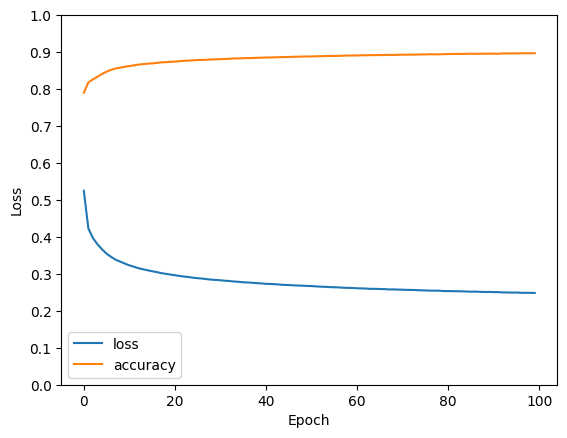

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.ylim(0,1)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()


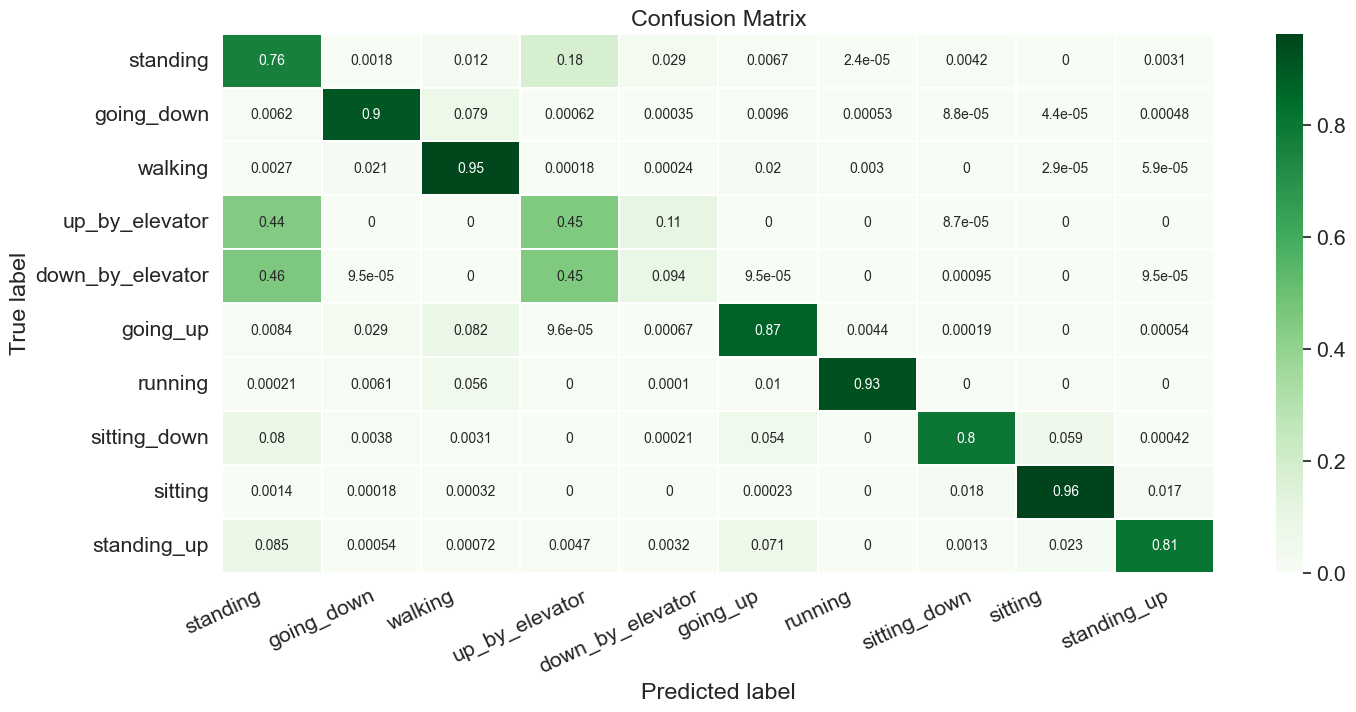

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['standing', 'going_down', 'walking', 'up_by_elevator', 'down_by_elevator', 'going_up', 'running', 'sitting_down', 'sitting', 'standing_up']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('HuGa_model.keras')

In [ ]:
history2 = model.fit(X_train, y_train, epochs=160, verbose=1, batch_size=64)